# Introducing the gosduma7 Dataset

In [1]:
# Some initialization magic
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Let's load up the data
import json

with open("scrapyproject/results.json") as fin:
    lines = [json.loads(line) for line in fin]

In [2]:
# Here's what it looks like. Each line corresponds to a single electorate.
lines[0]["electorate"]

'Республика Адыгея (Адыгея) - Адыгейский'

In [3]:
# For each we keep the votes broken down by party, and further broken down by the polling station
# Thus, for the Adygea electorate, the Rodina party achieved 2065 votes across the 9 polling stations.
lines[0]["votes"][0]

{'stations': [{'name': 'Адыгейская', 'value': 9.0},
  {'name': 'Гиагинская', 'value': 135.0},
  {'name': 'Кошехабльская', 'value': 137.0},
  {'name': 'Красногвардейская', 'value': 59.0},
  {'name': 'Майкопская', 'value': 327.0},
  {'name': 'Майкопская городская', 'value': 1105.0},
  {'name': 'Тахтамукайская', 'value': 268.0},
  {'name': 'Теучежская', 'value': 6.0},
  {'name': 'Шовгеновская', 'value': 19.0}],
 'subtitle': '1. ВСЕРОССИЙСКАЯ ПОЛИТИЧЕСКАЯ ПАРТИЯ "РОДИНА"',
 'total_value': 2065.0}

In [4]:
# We also keep the overall stats for the electorate.
# Thus, the Adygea electorate consisted of 339685 eligible votes across the 9 polling stations.
lines[0]["stats"][0]

{'stations': [{'name': 'Адыгейская', 'value': 11932.0},
  {'name': 'Гиагинская', 'value': 24743.0},
  {'name': 'Кошехабльская', 'value': 22779.0},
  {'name': 'Красногвардейская', 'value': 21925.0},
  {'name': 'Майкопская', 'value': 46456.0},
  {'name': 'Майкопская городская', 'value': 130529.0},
  {'name': 'Тахтамукайская', 'value': 55175.0},
  {'name': 'Теучежская', 'value': 13768.0},
  {'name': 'Шовгеновская', 'value': 12378.0}],
 'subtitle': 'Число избирателей, внесенных в список избирателей на момент окончания голосования',
 'total_value': 339685.0}

In [5]:
# The order of parties is the same across the entire dataset. Let's grab it for later.
party_index = dict((b, a) for (a, b) in enumerate([party["subtitle"] for party in lines[0]["votes"]]))
party_index

{'1. ВСЕРОССИЙСКАЯ ПОЛИТИЧЕСКАЯ ПАРТИЯ "РОДИНА"': 0,
 '10. Общественная организация Всероссийская политическая партия "Гражданская Сила"': 9,
 '11. Политическая партия "Российская объединенная демократическая партия "ЯБЛОКО"': 10,
 '12. Политическая партия "КОММУНИСТИЧЕСКАЯ ПАРТИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ"': 11,
 '13. Политическая партия "ПАТРИОТЫ РОССИИ"': 12,
 '14. Политическая партия СПРАВЕДЛИВАЯ РОССИЯ': 13,
 '2. Политическая партия КОММУНИСТИЧЕСКАЯ ПАРТИЯ КОММУНИСТЫ РОССИИ': 1,
 '3. Политическая партия "Российская партия пенсионеров за справедливость"': 2,
 '4. Всероссийская политическая партия "ЕДИНАЯ РОССИЯ"': 3,
 '5. Политическая партия "Российская экологическая партия "Зеленые"': 4,
 '6. Политическая партия "Гражданская Платформа"': 5,
 '7. Политическая партия ЛДПР - Либерально-демократическая партия России': 6,
 '8. Политическая партия "Партия народной свободы" (ПАРНАС)': 7,
 '9. Всероссийская политическая партия "ПАРТИЯ РОСТА"': 8}

In [6]:
# ... and let's do the same for the stats.
stats_index = dict((b, a) for (a, b) in enumerate([stat["subtitle"] for stat in lines[0]["stats"]]))
stats_index

{'Число действительных избирательных бюллетеней': 9,
 'Число избирателей, внесенных в список избирателей на момент окончания голосования': 0,
 'Число избирателей, проголосовавших по открепительным удостоверениям на избирательном участке': 12,
 'Число избирательных бюллетеней, выданных в помещении для голосования в день голосования': 3,
 'Число избирательных бюллетеней, выданных вне помещения для голосования в день голосования': 4,
 'Число избирательных бюллетеней, выданных избирателям, проголосовавшим досрочно': 2,
 'Число избирательных бюллетеней, полученных участковой избирательной комиссией': 1,
 'Число избирательных бюллетеней, содержащихся в переносных ящиках для голосования': 6,
 'Число избирательных бюллетеней, содержащихся в стационарных ящиках для голосования': 7,
 'Число недействительных избирательных бюллетеней': 8,
 'Число открепительных удостоверений, выданных избирателям территориальной избирательной комиссией': 14,
 'Число открепительных удостоверений, выданных на избира

# Recreating the Graph from [Slon.ru](https://tjournal.ru/34502-zhurnalisti-slonru-matematicheski-obnaruzhili-priznaki-masshtabnih-falsifikacii-na-viborah-v-gosdumu)
The X-axis shows the percentage of votes gained, from 0.00 to 1.00. The Y-axis shows the total votes for that party across all polling stations with the specified percentage of votes for a particular party.

In [7]:
import collections
import scipy.signal


def extract_stations(full_party_name):
    """Extract statistics for each polling station."""
    total_voters = 'Число избирателей, внесенных в список избирателей на момент окончания голосования'
    total_voters_idx = stats_index[total_voters]
    
    total_ballots = 'Число действительных избирательных бюллетеней'
    total_ballots_idx = stats_index[total_ballots]
    
    party_idx = party_index[full_party_name]

    stations = []
    for electorate in lines:
        # The total number of voters at each station electorate
        assert electorate["stats"][total_voters_idx]["subtitle"] == total_voters
        voters = {}
        for station in electorate["stats"][total_voters_idx]["stations"]:
            voters[station["name"]] = station["value"]
            
        # Calculate the turnout as the number of valid ballots out of the total number of voters for that station
        turnout = {}
        for station in electorate["stats"][total_ballots_idx]["stations"]:
            turnout[station["name"]] = station["value"] / voters[station["name"]]

        # Votes for the specified party across all stations.
        assert electorate["votes"][party_idx]["subtitle"] == full_party_name
        for station in electorate["votes"][party_idx]["stations"]:        
            stations.append(
                {
                    "electorate": electorate["electorate"],
                    "station": station["name"],
                    "fraction": station["value"] / voters[station["name"]],
                    "votes": station["value"],
                    "turnout": turnout[station["name"]]
                }
            )
    return stations

def round_nearest(x, a=0.002):
    """Round the x-value to the nearest a-value."""
    # http://stackoverflow.com/questions/28425705/python-rounding-a-floating-point-number-to-nearest-0-05
    return round(x / a) * a


def bin_by(stations, key="fraction"):
    """Bin each polling station by the fraction of votes for some (arbitrary) party."""
    bins = collections.defaultdict(list)
    for station in stations:
        bins[round_nearest(station[key])].append(station)
    return sorted(bins.items())


def box_filter(y, box_pts=9):
    """Smoooth the y-signal using a regular box filter of the specified width."""
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

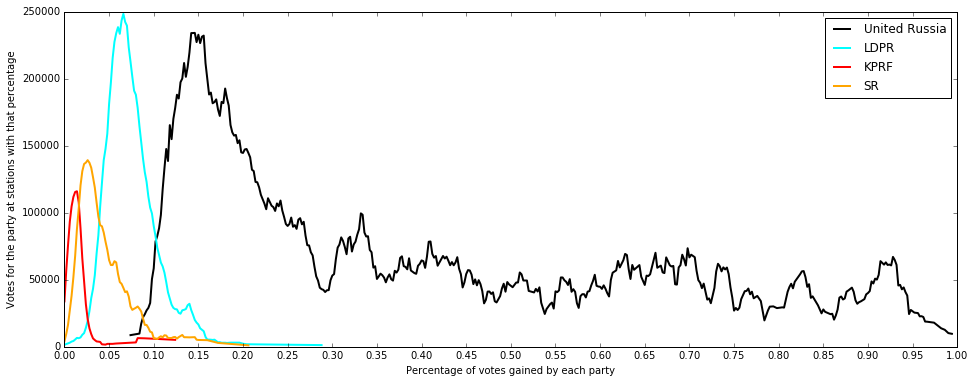

In [8]:
united_bins = bin_by(extract_stations('4. Всероссийская политическая партия "ЕДИНАЯ РОССИЯ"'))
ldpr_bins = bin_by(extract_stations('7. Политическая партия ЛДПР - Либерально-демократическая партия России'))
kprf_bins = bin_by(extract_stations('2. Политическая партия КОММУНИСТИЧЕСКАЯ ПАРТИЯ КОММУНИСТЫ РОССИИ'))
sr_bins = bin_by(extract_stations('14. Политическая партия СПРАВЕДЛИВАЯ РОССИЯ'))

plt.figure(figsize=(16, 6))
linewidth = 2

x1 = [val for (val, _) in united_bins]
y1 = [sum(st["votes"] for st in stations) for (_, stations) in united_bins]
y1 = box_filter(y1)
plt.plot(x1, y1, linewidth=linewidth, label="United Russia", color="black")

x2 = [val for (val, _) in ldpr_bins]
y2 = [sum(st["votes"] for st in stations) for (_, stations) in ldpr_bins]
y2 = box_filter(y2)
plt.plot(x2, y2, linewidth=linewidth, label="LDPR", color="cyan")

x3 = [val for (val, _) in kprf_bins]
y3 = [sum(st["votes"] for st in stations) for (_, stations) in kprf_bins]
y3 = box_filter(y3)
plt.plot(x3, y3, linewidth=linewidth, label="KPRF", color="red")

x4 = [val for (val, _) in sr_bins]
y4 = [sum(st["votes"] for st in stations) for (_, stations) in sr_bins]
y4 = box_filter(y4)
plt.plot(x4, y4, linewidth=linewidth, label="SR", color="orange")

plt.xticks(np.arange(0, 1.05, 0.05))
plt.ylabel("Votes for the party at stations with that percentage")
plt.xlabel("Percentage of votes gained by each party")

plt.legend()

print()

# Let's Try the Voter Turnout Graph
The X-axis shows the turnout percentage, calculated as the number of valid ballots divided by the total number of eligible voters. The Y-axis shows the total number of votes for each party for each polling station with the specified turnout.

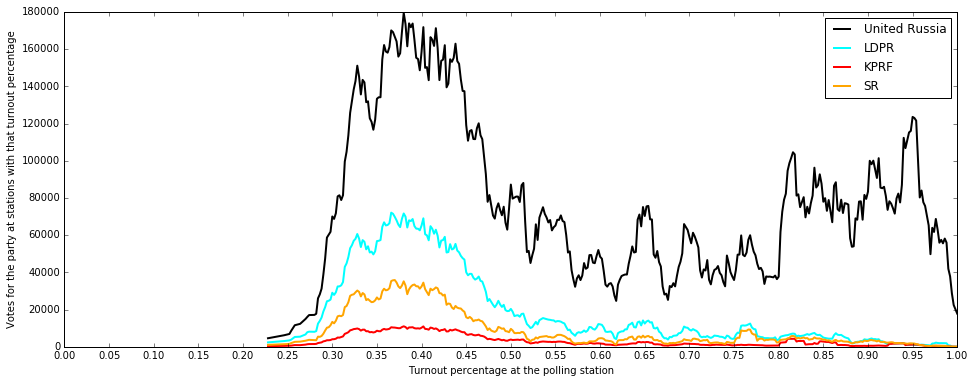

In [9]:
united_bins = bin_by(extract_stations('4. Всероссийская политическая партия "ЕДИНАЯ РОССИЯ"'), key="turnout")
ldpr_bins = bin_by(extract_stations('7. Политическая партия ЛДПР - Либерально-демократическая партия России'), key="turnout")
kprf_bins = bin_by(extract_stations('2. Политическая партия КОММУНИСТИЧЕСКАЯ ПАРТИЯ КОММУНИСТЫ РОССИИ'), key="turnout")
sr_bins = bin_by(extract_stations('14. Политическая партия СПРАВЕДЛИВАЯ РОССИЯ'), key="turnout")

plt.figure(figsize=(16, 6))
linewidth = 2

x1 = [val for (val, _) in united_bins]
y1 = [sum(st["votes"] for st in stations) for (_, stations) in united_bins]
y1 = box_filter(y1)
plt.plot(x1, y1, linewidth=linewidth, label="United Russia", color="black")

x2 = [val for (val, _) in ldpr_bins]
y2 = [sum(st["votes"] for st in stations) for (_, stations) in ldpr_bins]
y2 = box_filter(y2)
plt.plot(x2, y2, linewidth=linewidth, label="LDPR", color="cyan")

x3 = [val for (val, _) in kprf_bins]
y3 = [sum(st["votes"] for st in stations) for (_, stations) in kprf_bins]
y3 = box_filter(y3)
plt.plot(x3, y3, linewidth=linewidth, label="KPRF", color="red")

x4 = [val for (val, _) in sr_bins]
y4 = [sum(st["votes"] for st in stations) for (_, stations) in sr_bins]
y4 = box_filter(y4)
plt.plot(x4, y4, linewidth=linewidth, label="SR", color="orange")

plt.xticks(np.arange(0, 1.05, 0.05))
plt.ylabel("Votes for the party at stations with that turnout percentage")
plt.xlabel("Turnout percentage at the polling station")

plt.legend()

print()